In [88]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [157]:
def eq_covariance(inputs,
                  scale,
                  cov_coeff,
                  noise_coeff):
    
    diff = inputs[:, None] - inputs[None, :]
    
    quad = (diff / (2 * scale ** 2)) ** 2
    
    exp_quad = cov_coeff ** 2 * np.exp(- quad)
    exp_quad = exp_quad + noise_coeff ** 2 * np.eye(quad.shape[0])
    
    return exp_quad


def sample_dataset(num_train,
                   num_test,
                   scale,
                   cov_coeff,
                   noise_coeff,
                   as_tensor):
    
    x_train_test = np.random.uniform(low=-3., high=3., size=(num_train + num_test,))

    cov_train_test = eq_covariance(x_train_test,
                                   scale,
                                   cov_coeff,
                                   noise_coeff)
    
    y_train_test = np.random.multivariate_normal(np.zeros(cov_train_test.shape[0]), cov_train_test)
    
    x_train = x_train_test[:num_train]
    x_test = x_train_test[num_train:]
    
    y_train = y_train_test[:num_train]
    y_test = y_train_test[num_train:]
    
    
    x_train, y_train, x_test, y_test = [torch.tensor(array).float() if as_tensor else array \
                                        for array in (x_train, y_train, x_test, y_test)]
    
    return (x_train, y_train), (x_test, y_test)

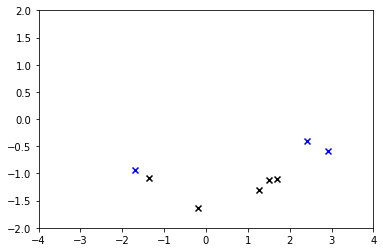

In [158]:
num_train = 5
num_test = 3
lengthscale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = False

train_data, test_data = sample_dataset(num_train,
                                       num_test,
                                       lengthscale,
                                       cov_coeff,
                                       noise_coeff,
                                       as_tensor)

plt.scatter(train_data[0], train_data[1], marker='x', color='black')
plt.scatter(test_data[0], test_data[1], marker='x', color='blue')

plt.xlim([-4, 4])
plt.ylim([-2, 2])
plt.show()

In [159]:
class FeedforwardNetwork(nn.Module):
    
    
    def __init__(self,
                 input_dim,
                 output_dim,
                 nums_hidden,
                 nonlinearity):
        
        super().__init__()
        
        sizes = [input_dim] + nums_hidden + [output_dim]
        sizes = [(s1, s2) for s1, s2 in zip(sizes[:-1], sizes[1:])]
        
        self.linear = [nn.Linear(s1, s2, bias=True) for s1, s2 in sizes]
        self.linear = nn.ModuleList(self.linear)
        
        self.nonlinearity = getattr(nn, nonlinearity)()
        
    
    def forward(self, tensor):
        
        for linear in self.linear[:-1]:
            
            tensor = linear(tensor)
            tensor = self.nonlinearity(tensor)
            
        tensor = self.linear[-1](tensor)
        
        return tensor
    
    
class ConditionalNeuralProcess(nn.Module):
    
    def __init__(self,
                 discriminator,
                 encoder):
        
        
        super().__init__()
        
        self.discriminator = discriminator
        self.encoder = encoder
        
        self.normal = torch.distributions.Normal
        
        
    def forward(self, tensor):
        
        tensor = torch.reshape(tensor, (-1, 1))
        
        theta = self.encoder(tensor)
        theta = torch.mean(theta, dim=0)[None, :]
        theta = theta.repeat(tensor.shape[0], 1)
        
        tensor = torch.cat([tensor, theta], dim=-1)
        
        tensor = self.discriminator(tensor)
        
        return tensor
    
    
    def loss(self, inputs, outputs):
        
        model_outputs = self.forward(inputs)
        
        cond_dist = self.normal(logits=model_outputs)
        
        log_prob = cond_dist.log_prob(outputs)
        
        return log_prob

In [160]:
discriminator = FeedforwardNetwork(input_dim=65,
                                   output_dim=2,
                                   nums_hidden=[64, 64],
                                   nonlinearity='ReLU')

encoder = FeedforwardNetwork(input_dim=1,
                             output_dim=64,
                             nums_hidden=[64, 64],
                             nonlinearity='ReLU')

In [161]:
conditional_neural_process = ConditionalNeuralProcess(discriminator=discriminator,
                                                      encoder=encoder)

conditional_neural_process(torch.ones(1,))

tensor([[-0.0195,  0.1198]], grad_fn=<AddmmBackward>)

In [162]:
num_train = 5
num_test = 3
lengthscale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = True

train_data, test_data = sample_dataset(num_train,
                                       num_test,
                                       lengthscale,
                                       cov_coeff,
                                       noise_coeff,
                                       as_tensor)

inputs, outputs = train_data

conditional_neural_process = ConditionalNeuralProcess(discriminator=discriminator,
                                                      encoder=encoder)

print(conditional_neural_process(inputs))

conditional_neural_process(inputs)

tensor([[-0.0234,  0.1275],
        [-0.0105,  0.1127],
        [-0.0137,  0.1236],
        [-0.0239,  0.1277],
        [-0.0002,  0.1031]], grad_fn=<AddmmBackward>)

In [165]:
# Dataset parameters
num_train = 5
num_test = 3
lengthscale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = True

# Training parameters and optimizer
num_train_steps = 1000
lr = 1e-4

conditional_neural_process = ConditionalNeuralProcess(discriminator=discriminator,
                                                      encoder=encoder)

optimizer = torch.optim.Adam(conditional_neural_process.parameters(), lr=lr)


for i in trange(100):
    
    